# Sensitivity Analysis of the Satellite Observations Dataset

In this part we perform a preliminary statistical analysis of the variables contained in the dataset, and the relationships that arise at a first glance

Libraries we need are imported first

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import xarray as xr
from scipy.interpolate import griddata
from scipy import interpolate
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

We then perform all the steps in the previous notebook at once for reading and preprocessing the data

In [8]:
thefile = '../../../DATA/TPdata_199301'
data = pd.read_csv(thefile, sep='\t', header=None)
data.columns = ["cellNr", "latitude", "longitude", "backscatter","emissivity_v","emissivity_h","ts_amplitude","ndvi","lmd_soilWetness"]
data = data.replace('   NaN',pd.NA)
data['backscatter'] = pd.to_numeric(data['backscatter'])
data['emissivity_v'] = pd.to_numeric(data['emissivity_v'])
data['emissivity_h'] = pd.to_numeric(data['emissivity_h'])
data['ts_amplitude'] = pd.to_numeric(data['ts_amplitude'])
data['ndvi'] = pd.to_numeric(data['ndvi'])
data['lmd_soilWetness'] = pd.to_numeric(data['lmd_soilWetness'])

In this step we remove all the grid points where there is no data in any of the variables as we aim to combine the information contained in all the variables to build our soil moisture index.

In [12]:
data = data.dropna()

## Scatter Plots

We start by creating scatter plots for each pair of variables to spot correlations and redundancies and collinearities. This is done with the built in scatter_matrix in pandas: 

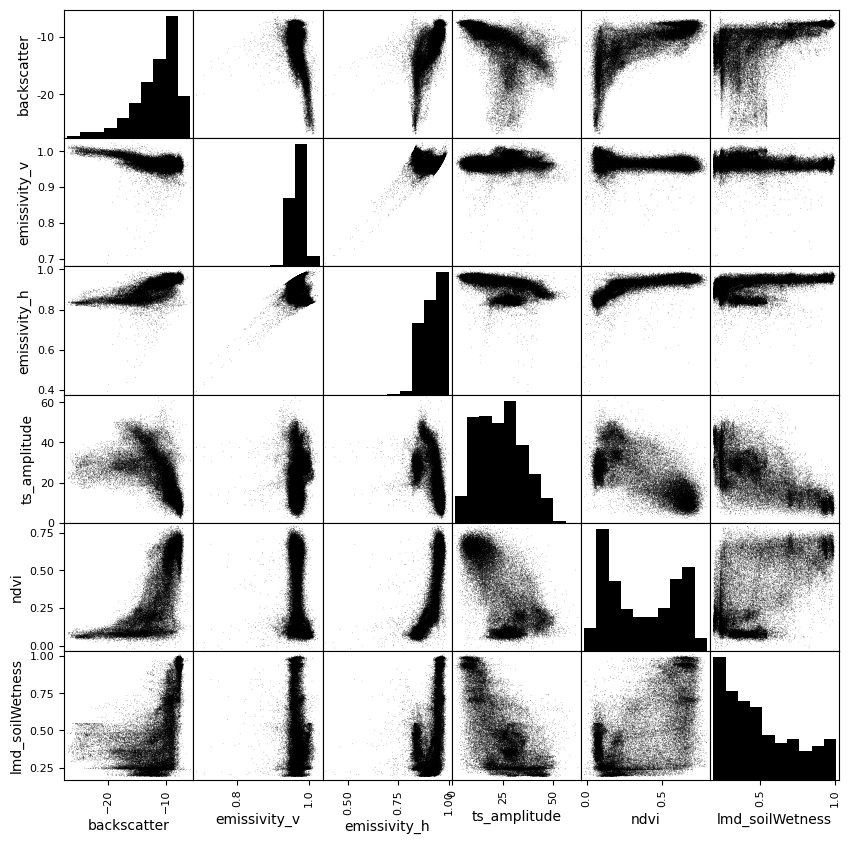

In [17]:
fig, ax = pl.subplots(figsize=(10, 10)) 
ax = pd.plotting.scatter_matrix(data[['backscatter', 'emissivity_v','emissivity_h','ts_amplitude','ndvi','lmd_soilWetness']],ax=ax,s=1,c='k',hist_kwds={'color':['black']});

Intuitively there seems to be some weak correlation between the ts_amplitude variable and the lmd_soilwetness dataproduct that we will analyse further on. Regarding all the other variables, there is not a clear relationship between them pointing towards a linear relationship. 

## Correlation Coefficients

A quick look at the correlation coefficients provides a glimpse on the relationships numerically in addition to the scatter plots. For this we use the .corr() function from pandas. 

In [24]:
data.corr(min_periods=3)

,cellNr,latitude,longitude,backscatter,emissivity_v,emissivity_h,ts_amplitude,ndvi,lmd_soilWetness
cellNr,1.000000,0.999673,-0.070898,-0.244974,0.191138,-0.324772,-0.142787,-0.411075,-0.012247
latitude,0.999673,1.000000,-0.068802,-0.238776,0.188661,-0.319454,-0.148162,-0.405415,-0.010330
longitude,-0.070898,-0.068802,1.000000,-0.282649,0.059293,-0.273794,0.433614,-0.342926,-0.321579
backscatter,-0.244974,-0.238776,-0.282649,1.000000,-0.546260,0.734116,-0.543246,0.731294,0.507656
emissivity_v,0.191138,0.188661,0.059293,-0.546260,1.000000,-0.007722,0.085045,-0.230334,-0.148656
emissivity_h,-0.324772,-0.319454,-0.273794,0.734116,-0.007722,1.000000,-0.512372,0.804035,0.467541
ts_amplitude,-0.142787,-0.148162,0.433614,-0.543246,0.085045,-0.512372,1.000000,-0.689494,-0.686003
ndvi,-0.411075,-0.405415,-0.342926,0.731294,-0.230334,0.804035,-0.689494,1.000000,0.604335
lmd_soilWetness,-0.012247,-0.010330,-0.321579,0.507656,-0.148656,0.467541,-0.686003,0.604335,1.000000


In general values are far from the ideal 1 to spot clear linearities between variables, in sync with the results observed looking at the scatter plots 

## Simple Linear Regression

We perform a simple linear regression between the two variables that seem to correlate the most, i.e., the LMD dataproduct and the surface temperature amplitude. 

In [27]:
X = pd.DataFrame({'intercept':np.ones(data.shape[0]),'TS_amplitude':data['ts_amplitude']})

For this we use the statsmodels package, with built in functions for the simple linear regression

In [30]:
y = data['lmd_soilWetness']
model = sm.OLS(y,X)
results = model.fit()

Results are as follows: 

In [115]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        lmd_soilWetness   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                 3.958e+04
Date:                Tue, 15 Jul 2025   Prob (F-statistic):               0.00
Time:                        13:22:08   Log-Likelihood:                 15593.
No. Observations:               44531   AIC:                        -3.118e+04
Df Residuals:                   44529   BIC:                        -3.116e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.8444      0.002    437.677      0.000       0.841       0.848
TS_amplitude    -0.0145   7.29e-05   -198.955      0.000      -0.015      -0.014
==============================================================================
Omnibus:                      846.429   Durbin-Watson:                   0.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.497
Skew:                          -0.088   Prob(JB):                    2.54e-108
Kurtosis:                       2.514   Cond. No.                         63.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The r2 value is still low, showing that a simple linear regression is far from describing the relationship between both variables. 

In [117]:
results.params

intercept       0.844423
TS_amplitude   -0.014513
dtype: float64

We plot the regression line using these slope and intercept values through: 

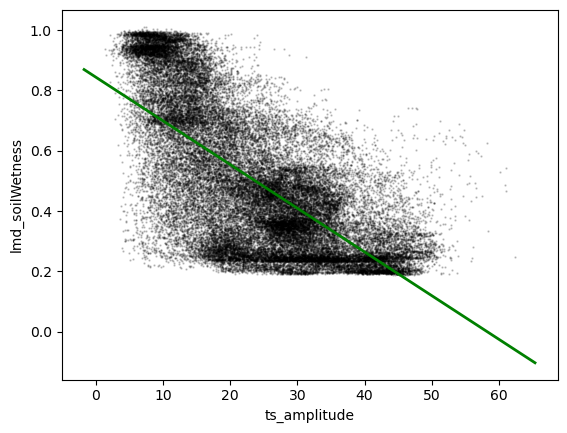

In [35]:
def abline(ax, b,m):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim,ylim,c='g',linewidth=2)
ax = data.plot.scatter('ts_amplitude','lmd_soilWetness',s=.5,color='k',alpha=0.2)
abline(ax, results.params[0],results.params[1])

We observe that a substantial amount of datapoints lie far from the simple linear regression line, that is not able to describe the whole behaviour of the soil moisture index based on a single variable. 

Additional statistical methods are required to fully describe the soil moisture dataproduct derived from satellite observations. 